## Do men earn more than women?


It is often reported that women earn more than men. The Ontario government (in Canada) reports the salary of all public-sector employees making more than a given amount. This data is freely available.

In [1]:
# Import all I need (boring)
import sys
# uncomment if you are missing packages
#!{sys.executable} -m pip install --upgrade --force-reinstall  unidecode msgpack kiwisolver pandas sklearn matplotlib numpy
#!{sys.executable} -m pip freeze
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dataset = pd.read_csv("fr-2017-pssd-compendium-20180320-utf8.csv")
dataset.head(5)


,Secteur,Nom de famille,Prénom,Traitement versé,Avantages imposables,Employeur,Poste,Année civile
0,Autres employeurs du secteur public,Coleridge,Peter,"$250,000.00","$25,749.50",Big Brothers Big Sisters of Canada,National President and Chief Executive Officer,2017
1,Autres employeurs du secteur public,Chater,W. Matthew,"$100,877.00","$2,778.27",Big Brothers Big Sisters of Canada,"National Vice-President, Service and Organizat...",2017
2,Autres employeurs du secteur public,Mcintyre,Mary Ellen,"$113,847.58","$19,015.00",Centre For Spanish Speaking Peoples,Legal Director,2017
3,Autres employeurs du secteur public,Marlin,Susan,"$248,068.75",$258.48,Clinical Trials Ontario,President and Chief Executive Officer,2017
4,Autres employeurs du secteur public,Frampton,Peter,"$165,033.85","$10,788.30",Learning Enrichment Foundation,Executive Director,2017


How many people do we have? About 130 thousands.

In [3]:
dataset.shape

(131741, 8)

It looks good but the file contains numbers as "$113,847.58". It is not recognized by Python as a number. So we need to remove the '$' and the ',' before we can parse it as a number. So we call the "replace" function.

In [4]:
dataset["salaire"]=dataset['Traitement versé'].replace( '[\$,]','', regex=True ).astype(float) + dataset['Avantages imposables'].replace( '[\$,]','', regex=True ).astype(float)
pd.options.display.float_format = '${:,.2f}'.format

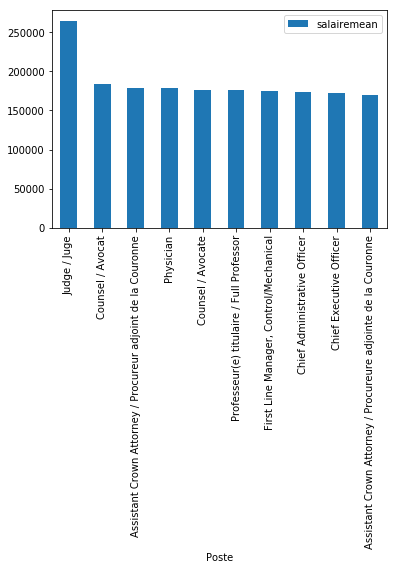

In [5]:
salaireparposte=dataset.groupby("Poste").agg({'salaire':[np.size,np.mean]}).reset_index()
salaireparposte=salaireparposte[salaireparposte[("salaire","size")]>200].sort_values(("salaire","mean"),ascending=False)
salaireparposte.columns = [col[0]+col[1] for col in salaireparposte.columns]

salaireparposte[["Poste","salairemean"]].set_index('Poste').head(10).plot.bar()


In [6]:
dataset.head(5)

,Secteur,Nom de famille,Prénom,Traitement versé,Avantages imposables,Employeur,Poste,Année civile,salaire
0,Autres employeurs du secteur public,Coleridge,Peter,"$250,000.00","$25,749.50",Big Brothers Big Sisters of Canada,National President and Chief Executive Officer,2017,"$275,749.50"
1,Autres employeurs du secteur public,Chater,W. Matthew,"$100,877.00","$2,778.27",Big Brothers Big Sisters of Canada,"National Vice-President, Service and Organizat...",2017,"$103,655.27"
2,Autres employeurs du secteur public,Mcintyre,Mary Ellen,"$113,847.58","$19,015.00",Centre For Spanish Speaking Peoples,Legal Director,2017,"$132,862.58"
3,Autres employeurs du secteur public,Marlin,Susan,"$248,068.75",$258.48,Clinical Trials Ontario,President and Chief Executive Officer,2017,"$248,327.23"
4,Autres employeurs du secteur public,Frampton,Peter,"$165,033.85","$10,788.30",Learning Enrichment Foundation,Executive Director,2017,"$175,822.15"


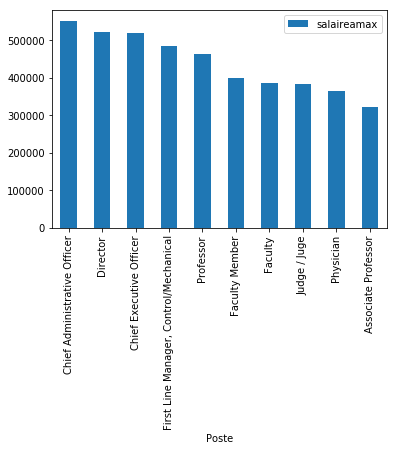

In [7]:
salaireparposte=dataset.groupby("Poste").agg({'salaire':[np.size,np.max]}).reset_index()
salaireparposte=salaireparposte[salaireparposte[("salaire","size")]>200].sort_values(("salaire","amax"),ascending=False)
salaireparposte.columns = [col[0]+col[1] for col in salaireparposte.columns]

salaireparposte[["Poste","salaireamax"]].set_index('Poste').head(10).plot.bar()



In [8]:
profsalaire = dataset[dataset['Poste'].str.contains("Prof") & ~(dataset['Poste'].str.contains("Dean"))]
profsalaire.sort_values("salaire",ascending=False)[["Nom de famille","Employeur","salaire"]].head(100)

,Nom de famille,Employeur,salaire
126061,Ganjavi,Laurentian University of Sudbury,"$686,965.86"
129478,Hull,University of Toronto,"$465,324.29"
122755,Yusuf,Mcmaster University,"$462,846.17"
128612,Christoffersen,University of Toronto,"$457,575.56"
130294,Mitchell,University of Toronto,"$451,223.87"
131556,Whyte,University of Toronto,"$449,973.45"
131210,Strange,University of Toronto,"$442,910.28"
128033,Aivazian,University of Toronto,"$441,261.26"
130167,Mccurdy,University of Toronto,"$436,216.96"
128022,Agrawal,University of Toronto,"$428,082.50"


Ok. So we have the dataset, but there is no gender identification. Thankfully, there are available statistical models that allow us to categorize first names.

In [9]:
genderstat =  pd.read_csv("us-likelihood-of-gender-by-name-in-2014.csv")
genderstat[["sex","name"]].head()

,sex,name
0,F,Elaine
1,F,Cathy
2,F,Heidi
3,F,Vicki
4,F,Melinda


 But first, let us check that things work as they should:

In [10]:
from unidecode import unidecode 
def gender_first_name(name):
    try: 
      return genderstat[genderstat['name'].map(lambda x : unidecode(x))==unidecode(name)][["sex"]].values[0][0]
    except:
      return "UNKNOWN"
for n in ["Nathalie", "Julie", "Pierre", "Yves", "Daniel", "Lohan"]:
    print(n, gender_first_name(n))

Nathalie F
Julie F
Pierre M
Yves M
Daniel M
Lohan UNKNOWN


Ok. So now we have two tables. What are we going to do to put the data back together? One solution is to use a "join".

We have a 'name' column in one dataset, and now we will create another name column on the other data set, after making sure to trim out accents so that "Éric" becomes "Eric".

In [11]:
from unidecode import unidecode 
dataset['name'] = dataset['Prénom'].apply(lambda n : unidecode(n) )
dataset[['name','Prénom']].head(10)

,name,Prénom
0,Peter,Peter
1,W. Matthew,W. Matthew
2,Mary Ellen,Mary Ellen
3,Susan,Susan
4,Peter,Peter
5,Therese,Therese
6,Daniel,Daniel
7,Deborah,Deborah
8,Shirley,Shirley
9,Sue,Sue


In [12]:
datasetwithgender=pd.merge(dataset,genderstat,on="name")

In [13]:
datasetwithgender.groupby("sex").size()

sex
F    43315
M    58417
dtype: int64

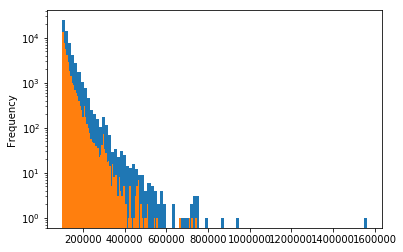

In [14]:
fig, ax = plt.subplots()
datasetwithgender[datasetwithgender["sex"]=="M"]["salaire"].plot.hist(ax=ax,bins=100)
datasetwithgender[datasetwithgender["sex"]=="F"]["salaire"].plot.hist(ax=ax, bins=100)
ax.set_yscale('log')

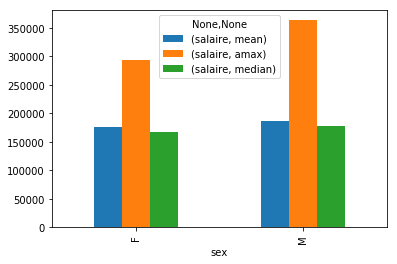

In [15]:
datasetwithgender[datasetwithgender["Poste"]=="Physician"].groupby(["sex"]).agg({'salaire':[np.mean,np.max,np.median]}).plot.bar()

In [16]:
datasetwithgender.groupby("sex").agg({'salaire':np.mean})

,salaire
sex,
F,"$123,879.68"
M,"$130,332.61"


In [17]:
datasetwithgender.groupby("sex").agg({'salaire':np.max})

,salaire
sex,
F,"$745,268.93"
M,"$1,561,320.95"


In [18]:
waterlooprofessor = datasetwithgender[(datasetwithgender["Employeur"]=="University of Waterloo")
                                      &(datasetwithgender["Poste"].str.contains("Professor"))]

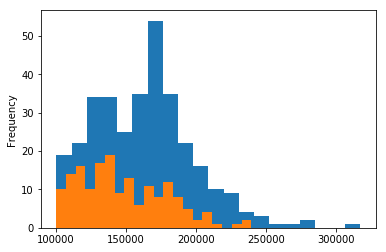

In [19]:
waterlooprofessor[waterlooprofessor["sex"]=="M"]["salaire"].plot.hist( bins=20)
waterlooprofessor[waterlooprofessor["sex"]=="F"]["salaire"].plot.hist( bins=20)

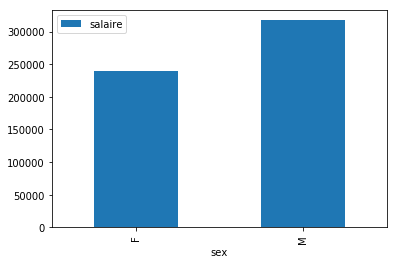

In [20]:
waterlooprofessor.groupby("sex").agg({'salaire':np.max}).plot.bar()

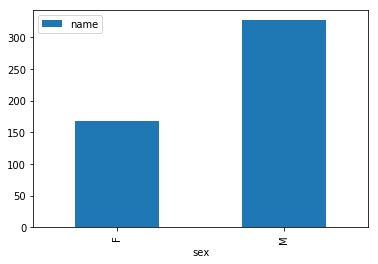

In [28]:
waterlooprofessor.groupby("sex").agg({'name':np.size}).plot.bar()

In [22]:
ottawaprofessor = datasetwithgender[(datasetwithgender["Employeur"]=="University of Ottawa")
                                      &(datasetwithgender["Poste"].str.contains("Professeur"))]
ottawaprofessor[['name','sex',"salaire"]].head(5)

,name,sex,salaire
796,Peter,M,"$185,750.40"
797,Peter,M,"$153,990.13"
798,Peter,M,"$153,903.36"
800,Peter,M,"$179,153.60"
801,Peter,M,"$185,766.00"


In [23]:
ottawaprofessor.groupby("sex").agg({'salaire':np.mean})

,salaire
sex,
F,"$147,084.86"
M,"$156,445.92"


In [24]:
ottawaprofessor.groupby("sex").agg({'salaire':np.max})

,salaire
sex,
F,"$237,641.00"
M,"$260,765.92"


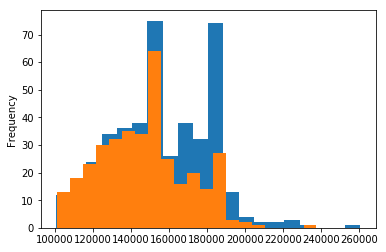

In [25]:

ottawaprofessor[ottawaprofessor["sex"]=="M"]["salaire"].plot.hist( bins=20)
ottawaprofessor[ottawaprofessor["sex"]=="F"]["salaire"].plot.hist( bins=20)